## Business Understanding
A stealth tech company is building a new product. Having failed a previous attempt at covert corporate espionage, they have hired me to gather positive public comments made on Twitter about Google and Apple products to help them understand people's favorite aspects of those products to incorporate them into their new product. The tool will flag tweets as either positive or non-positive (could be neutral or negative) for deeper analysis. The company has stated that they would like to flag as many positive tweets as possible while minimizing false positives (tweets incorrectly labeled as positive).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras import metrics
import tensorflow as tf
from tensorflow.keras import backend as K

from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import nltk
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Understanding

The csv file has ~9000 tweets, each labeled by a human reviewer as positive, neutral, or negative. ~1/3 are positive and ~2/3 are either neutral or negative. The accuracy of these labels is limited by the judgement of the humans who labeled the list, as well as the vagaries of emotion generally. Also, this data's applicability to current technology and current language/slang trends may be limited by the fact that it is now over 10 years old.

In [2]:
# Read the csv file and display basic info
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# Data Preparation

In [4]:
# Remove na's and duplicates
df.dropna(subset=['tweet_text'], inplace=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)

In [5]:
# Remove tweets that humans were unable to identify and create a flag for positive tweets
neg_neut_combine = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
neg_neut_combine['pos_flag'] = 0
neg_neut_combine.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion', 'pos_flag'] = 1

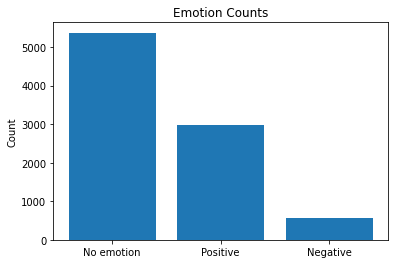

In [6]:
# Plot bar chart for full emotional breakdown
categories = ['No emotion', 'Positive', 'Negative']
total_emo_counts = neg_neut_combine['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

plt.bar(categories, total_emo_counts)
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

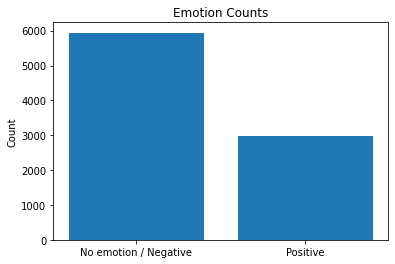

In [7]:
# Bar chart with negative and neutral tweets combined
categories = ['No emotion / Negative', 'Positive']
neg_neut_emo_counts = neg_neut_combine['pos_flag'].value_counts()

plt.bar(categories, neg_neut_emo_counts)
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

In [8]:
# Create variables for X and y, to be split into test, train, and validation sets
neg_neut_combine_tweets = neg_neut_combine['tweet_text'].copy()
neg_neut_combine_sentiment = neg_neut_combine['pos_flag'].copy()

In [9]:
# Split off test data to be used for final evaluation
X_train, X_test, y_train, y_test = train_test_split(neg_neut_combine_tweets,neg_neut_combine_sentiment, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=neg_neut_combine_sentiment)

In [10]:
# I use a function in the sequential model later that automatically uses the last 20% of 
# the entries for validation. I am manually splitting the training and validation data the same way 
# here for consistency. I verified that there is no significant difference in the proportion of positive 
# tweets between the training and validation sets.

X_train_baseline = X_train[:int(len(X_train) * 0.8)]
y_train_baseline = y_train[:int(len(y_train) * 0.8)]
X_val_baseline = X_train[-int(len(X_train) * 0.2):]
y_val_baseline = y_train[-int(len(y_train) * 0.2):]

# Modeling

### Baseline Model

I chose to use a TF-IDF vectorizer and logistic regression model as a straightforward first baseline model. The company wants to maximize the number of correctly identified tweets, but also doesn't want to have excessive false positives. Therefore the F1 score has been chosen as the metric by which these models will be judged, as it is a combination metric that takes into account both factors.

In [11]:
# Create a pipeline
clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('lr', LogisticRegression(max_iter=1000))
])

# Train
clf.fit(X_train_baseline, y_train_baseline)

# List most positive words
vectorizer = clf.named_steps["tfidf"]
classifier = clf.named_steps["lr"]

feature_names = vectorizer.get_feature_names_out()
coef = classifier.coef_[0]
top_pos_idx = coef.argsort()[-10:][::-1]
print("Top words for positive class:", feature_names[top_pos_idx])

# top_neg_idx = coef.argsort()[:10]
# print("Top words for negative/neutral class:", feature_names[top_neg_idx])

Top words for positive class: ['cool' 'great' 'ipad' 'good' 'love' 'wow' 'awesome' 'nice' 'excited'
 'fun']


In [12]:
# Get the F1 score from the validation set
ave_type = 'macro'
y_pred_val_base = clf.predict(X_val_baseline)
baseline_f1 = f1_score(y_val_baseline, y_pred_val_base, average=ave_type)
baseline_accuracy = accuracy_score(y_val_baseline, y_pred_val_base)
print(baseline_f1)

0.6466100474178859


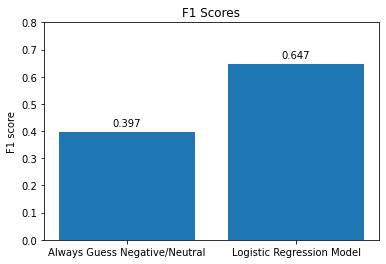

In [13]:
# Calculate comparison score based on always guessing majority class (negative/neutral)
y_pred2 = [0]*len(y_val_baseline)
majority_guess_f1 = f1_score(y_val_baseline, y_pred2, average=ave_type)
majority_guess_acc = accuracy_score(y_val_baseline, y_pred2)

categories = ['Always Guess Negative/Neutral', 'Logistic Regression Model']
f1s = [majority_guess_f1,baseline_f1]

plt.bar(categories, f1s)
plt.ylim(0, 0.8)
plt.ylabel('F1 score')
plt.title('F1 Scores')
for i, count in enumerate(f1s):
    plt.text(i, count+.02, str(round(count,3)), ha='center')
plt.show()

### Sequential Neural Network Model

This model was built to allow it to be called with multiple parameters specified and to be used for either a binary or multi-class classification, in case it was necessary to separate positive, neutral, and negative tweets. The run_pipe function takes in training data and parameters, then creates the pipeline, preps the data, trains the model, and returns the results.

It took some time to find an approach that worked the way I wanted it to. Numerous articles and posts were helped me develop the structure of the function below, most particularly: https://prappleizer.github.io/Tutorials/OOP/OOP_and_Classes.html.

In [14]:
def run_pipe(X,y, num_words=2000, 
             remove_stopwords=False, 
             lemmatize=False, 
             num_epochs=200, 
             show_results=False, 
             balance_classes=False):

# Compute weights to combat data imbalance, if necessary
    classes = np.unique(y)
    class_weights = [1]*len(classes)
    if balance_classes:
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y)
    class_weights = dict(zip(classes,class_weights))

# Text prep transformer

    class TextPrep(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.remove_stopwords = remove_stopwords
            self.lemmatize = lemmatize
            self.stop_words = set(stopwords.words("english"))
            self.lemmatizer = WordNetLemmatizer()

    # Map POS tag to WordNet format to help with lemmatization
        def get_wordnet_pos(self, treebank_tag):
            if treebank_tag.startswith("J"):
                return wordnet.ADJ
            elif treebank_tag.startswith("V"):
                return wordnet.VERB
            elif treebank_tag.startswith("N"):
                return wordnet.NOUN
            elif treebank_tag.startswith("R"):
                return wordnet.ADV
            else:
                return wordnet.NOUN

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            if isinstance(X, np.ndarray):
                X = X.ravel()
            X = [str(x) for x in X]

            processed = []
            for text in X:
                words = word_tokenize(text)

                # Remove stopwords, if desired
                if self.remove_stopwords:
                    words = [w for w in words if w.lower() not in self.stop_words]

                # Lemmatize, if desired
                if self.lemmatize:
                    pos_tags = pos_tag(words)
                    words = [self.lemmatizer.lemmatize(w, self.get_wordnet_pos(tag)) 
                             for w, tag in pos_tags]
                processed.append(" ".join(words))
            return processed        

    class KerasTokenizer(BaseEstimator, TransformerMixin):
        def __init__(self, mode="binary"):
            self.num_words = num_words
            self.mode = mode
            self.tokenizer = Tokenizer(num_words=self.num_words)

        def fit(self, X, y=None):
            self.tokenizer.fit_on_texts(X)
            return self

        def transform(self, X):
            return self.tokenizer.texts_to_matrix(X, mode=self.mode)    
      
 # Build sequential model

    def build_model(input_dim, n_classes):
        model = Sequential()
        model.add(Dense(50, activation="relu", input_shape=(input_dim,)))
        model.add(Dense(25, activation="relu"))
        model.add(Dense(n_classes, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=['accuracy'],
            weighted_metrics=[])
        
        return model

# Create pipeline

    n_classes = len(np.unique(y))

    pipeline = Pipeline([
        ("prep", TextPrep()),
        ("tok", KerasTokenizer()),
        ("clf", KerasClassifier(
            build_fn=lambda: build_model(
                input_dim=pipeline.named_steps["tok"].num_words, 
                n_classes=n_classes),
            epochs=num_epochs,
            batch_size=256,
            verbose=0,
            validation_split=0.2, 
            callbacks=[EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)],
            class_weight=class_weights))
    ])
    
# Fit
    pipeline.fit(X, y)

# Validation results
    pipe_history = pipeline.named_steps["clf"].history_
    X_val = X[-int(len(X) * 0.2):]
    y_val = y[-int(len(y) * 0.2):]
    y_pred = pipeline.predict(X_val)
    pipe_f1 = f1_score(y_val, y_pred, average=ave_type)
    
   # Print more detailed results and extra plots, if desired
    if show_results:
        print(confusion_matrix(y_val, y_pred))
        print("Max Val Accuracy:", max(pipe_history["val_accuracy"]))
        print("F1 score: ", pipe_f1)
        plt.figure(figsize=(8,5))
        plt.plot(pipe_history["accuracy"], label="Train Accuracy")
        if "val_accuracy" in pipe_history:
            plt.plot(pipe_history["val_accuracy"], label="Validation Accuracy")
        plt.title("Epoch vs Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
    
    return max(pipe_history["val_accuracy"]), pipe_f1, pipeline;

This function generates the most predictive words for each class. It returns the words and their weights.

In [15]:
def get_top_words_by_model_weights(pipeline, top_n=10):

    # Pull tokenizer and model, and set variables for important elements
    tok = pipeline.named_steps["tok"].tokenizer
    vocab_size = tok.num_words
    word_index = tok.word_index
    inv_word_index = {v: k for k, v in word_index.items() if v < vocab_size}
    model = pipeline.named_steps["clf"].model_
    first_dense = model.layers[0]
    second_dense = model.layers[1]
    final_dense = model.layers[-1]
    
    # Get weights for each layer
    W1, b1 = first_dense.get_weights()
    W2, b2 = second_dense.get_weights()
    W3, b3 = final_dense.get_weights()
    
    # Calculate combined weights
    combined_weights = W1 @ W2 @ W3

    # Create top words list
    top_words = {}
    for class_idx in range(combined_weights.shape[1]):
        class_contrib = combined_weights[:, class_idx]
        top_indices = np.argsort(class_contrib)[-top_n:][::-1]
        top_words[class_idx] = [
            (inv_word_index.get(i, f"<UNK_{i}>"), class_contrib[i])
            for i in top_indices]

    return top_words

This function calls the run_pipe function multiple times with different parameters and stores the results. Creating my own function, rather than using GridSearchCV, allowed me to customize the inputs, outputs, and displays (the prints and plots) throughout the process.

In [16]:
def parameter_check (X_par, y_par, num_words_list, plot=True, balance_classes=False, show_results=False, pts_per_config=1):
    
    # Initialize results dataframe, counter, and flags.
    results=pd.DataFrame(columns=["number_of_words","val_accuracy", 'remove_stopwords', 'lemmatize', 'f1'])
    i=1
    stop_tf=False
    lem_tf=False
    best_f1 = 0
    
    # Loop through all configurations j times.
    for j in range(pts_per_config):
        for x in num_words_list:
            for stop_tf, lem_tf in product([False,True],[False,True]):
#             for stop_tf in [False,True]:
#                 for lem_tf in [False,True]:
                acc, f1, model=run_pipe(X_par,y_par, 
                                 num_words=x,
                                 remove_stopwords=stop_tf, 
                                 lemmatize=lem_tf, 
                                 balance_classes=balance_classes, 
                                 show_results=show_results)
                if f1>best_f1:
                    best_f1=f1
                    best_model=model

                print(f'({i} of {len(num_words_list)*pts_per_config*4}) Stopwords: {stop_tf}, Lemmatize: {lem_tf}, Number of words: {x}, Val accuracy: {round(acc,4)}, F1 score: {round(f1,4)}')
                new_row_data = {'number_of_words': [x], 'val_accuracy': [acc], 'remove_stopwords': [stop_tf], 'lemmatize': [lem_tf], 'f1': [f1]}
                new_row = pd.DataFrame(new_row_data)
                results = pd.concat([results,new_row], ignore_index=True)
                i += 1
        results["config"] = results.apply(
            lambda row: f"Stopwords={row['remove_stopwords']}, Lemmatize={row['lemmatize']}", axis=1)

    # Add baseline data to results dataframe.
    for num_word in num_words_list:
        baseline_row_data = {'number_of_words': [num_word], 'val_accuracy': [baseline_accuracy], 'f1': [baseline_f1], 'config': 'Baseline Linear Regression Model'}
        baseline_rows = pd.DataFrame(baseline_row_data)
        results = pd.concat([results,baseline_rows], ignore_index=True)
    results = results.sort_values("number_of_words")

    if plot:
        avg_data = results.groupby(["number_of_words", "config"], as_index=False)["f1"].mean()        
        fig, ax2 = plt.subplots(figsize=(10,6))
        sns.lineplot(
            data=avg_data,
            x="number_of_words",
            y="f1",
            hue="config",
            style="config",
            ax=ax2,
            markers=True,
            dashes=True)
        plt.title("Validation F1 Score vs Number of Words", fontsize=14)
        plt.xlabel("Number of Words", fontsize=12)
        plt.ylabel("Validation F1 Score", fontsize=12)
        plt.legend(title="Preprocessing Config")
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return results, best_model

(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.7182, F1 score: 0.6438
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.7281, F1 score: 0.6673
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7274, F1 score: 0.6672
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.7215, F1 score: 0.6568
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7419, F1 score: 0.7003
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7386, F1 score: 0.6832
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7432, F1 score: 0.6812
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.736, F1 score: 0.6885
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7479, F1 score: 0.6932
(10 of 20) Stopwords: False, Lemmatize: T

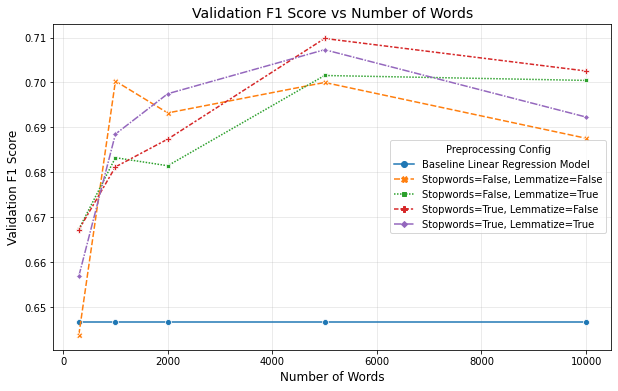

In [17]:
# Run parameter_check to evaluate unweighted models. The plot was too difficult to read with all of the parameters 
# running at once, so they have been broken up into two plots: weighted and unweighted.

num_words_list = [300, 1000, 2000, 5000, 10000]
unweighted_results, unweighted_model = parameter_check(X_train,y_train, num_words_list, show_results=False)

In [24]:
top_words = get_top_words_by_model_weights(unweighted_model, top_n=10)

print("Most positive words for best unweighted model:")
for word, weight in top_words[1]:
    print(f"{word:15s}")

Most positive words for best unweighted model:
genius         
cool           
brilliant      
excited        
laptops        
makes          
wow            
woot           
envy           
smart          


(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.7083, F1 score: 0.6659
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.7017, F1 score: 0.672
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7096, F1 score: 0.6772
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.7003, F1 score: 0.6716
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7333, F1 score: 0.7014
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7261, F1 score: 0.6919
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7215, F1 score: 0.691
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7168, F1 score: 0.6943
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7327, F1 score: 0.7016
(10 of 20) Stopwords: False, Lemmatize: Tr

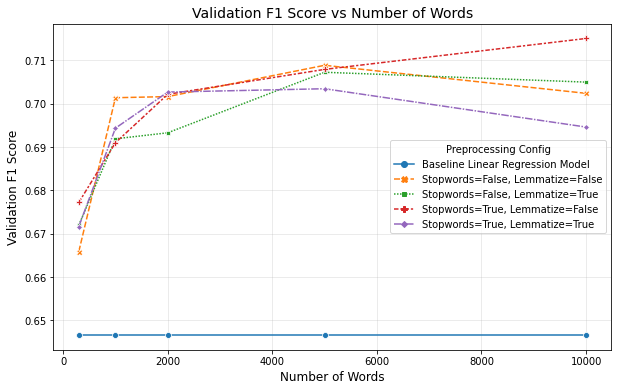

In [19]:
# Run parameter_check to evaluate weighted models.
num_words_list = [300, 1000, 2000, 5000, 10000]
weighted_results, weighted_model = parameter_check(X_train,y_train, num_words_list, balance_classes=True, show_results=False)

In [20]:
top_words = get_top_words_by_model_weights(weighted_model, top_n=10)

print("Most positive words for best weighted model:")
for word, weight in top_words[1]:
    print(f"{word:15s}")

Most positive words for best weighted model:
cool           
wow            
great          
envy           
makes          
excited        
woot           
hot            
genius         
smart          


# Evaluation

It is time to see the final results! An F1 score of 0.67 is generally considered acceptable to moderately good. Given the difficulties even humans have in classifying the emotional content of a message, this seems like a respectable result. The F1 score for the test data on the best model is slightly below the F1 score for the validation data, which is not abnormal. This indicates that the model is not significantly overfit to the validation data, which was used to determine the parameters for the final model. The stealth company now has a pared down list of positive tweets to analyze to glean insights for their new product.

In [21]:
weight_pred = weighted_model.predict(X_test)
round(f1_score(y_test, weight_pred, average=ave_type),3)

0.666

#### Next steps: 

As mentioned above, sentiment in a tweet is hard to determine - by man or machine. The stealth company could have multiple humans reclassify the tweets to ensure greater consistency in the labeled training data, though this would be time-consuming. If they are satisfied with the results of this model, I would be excited to see a further analysis of the most positively associated words to see if any particular features or feelings or sentiments pop up that would lead to insights for their product.